In [82]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter



# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [83]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['tal','con','mas','si','dos','pm','ser','ex','could'])


## Read News Outlets List

In [84]:
news_outlets = pd.read_csv("APRIL2019_DATABASE_State of the Latino News Media - MARCH2019_FINAL_MASTER_DATABASE.csv")
news_outlets.head(3)

,Estado,State,Medio,Media Outlet,Ciudad,City,Dirección,Zip Code,Latitud,Longitud,...,Fuentes de ingresos,Sources of Revenue,Número de empleados/Number of employees,Frecuencia,Frequency,Facebook,Twitter,Instagram,YouTube,Otra red social
0,Alabama,Alabama,Latino News,Latino News,Trussville,Trussville,PO Box 1313,35173,33.637321,-86.560208,...,NaN,NaN,NaN,Semanario,Weekly,https://www.facebook.com/LatinoNewspaper/,https://twitter.com/latinonews1,NaN,NaN,NaN
1,Alabama,Alabama,Alabama TV,Alabama TV,Hoover,Hoover,"2105 Lorna Ridge Lane, Suite 151",35216,33.391113,-86.796007,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/alabamatv/,https://twitter.com/AlabamaTv,https://www.instagram.com/alabamatv/,https://www.youtube.com/channel/UCdXIk0_d5kv_p...,NaN
2,Alabama,Alabama,Líder News,Líder News,Birmingham,Birmingham,PO Box 360535,35236,33.370188,-86.809721,...,Publicidad,Advertising,6-10,Semanal,Weekly,https://www.facebook.com/lidernews.alabama/,NaN,NaN,NaN,NaN


In [85]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [86]:
name_fb = news_outlets[['State','Facebook']].copy()
name_fb = name_fb[name_fb['Facebook'].notna()]

In [87]:
name_fb['clean_url'] = name_fb['Facebook'].apply(clean_address)
name_fb.head(3)

,State,Facebook,clean_url
0,Alabama,https://www.facebook.com/LatinoNewspaper/,latinonewspaper
1,Alabama,https://www.facebook.com/alabamatv/,alabamatv
2,Alabama,https://www.facebook.com/lidernews.alabama/,lidernews.alabama


In [88]:
posts1 = pd.read_csv("Media_Outlets1.csv")
posts2 = pd.read_csv("Media_Outlets2.csv")
posts = pd.concat([posts1,posts2],axis=0)
posts.shape

(9931, 31)

In [89]:
posts['URL']

0       https://www.facebook.com/univision/posts/10158...
1       https://www.facebook.com/mundohispanico/posts/...
2       https://www.facebook.com/mundohispanico/posts/...
3       https://www.facebook.com/mundohispanico/posts/...
4       https://www.facebook.com/mundohispanico/posts/...
                              ...                        
4201    https://www.facebook.com/UnivisionNuevoMexico/...
4202    https://www.facebook.com/UnivisionNuevoMexico/...
4203    https://www.facebook.com/UnivisionNuevoMexico/...
4204    https://www.facebook.com/UnivisionNuevoMexico/...
4205    https://www.facebook.com/UnivisionNuevoMexico/...
Name: URL, Length: 9931, dtype: object

In [90]:
posts['clean_url'] = posts['URL'].apply(clean_address)
posts['clean_url']

0                  univision
1             mundohispanico
2             mundohispanico
3             mundohispanico
4             mundohispanico
                ...         
4201    univisionnuevomexico
4202    univisionnuevomexico
4203    univisionnuevomexico
4204    univisionnuevomexico
4205    univisionnuevomexico
Name: clean_url, Length: 9931, dtype: object

In [91]:
posts_st =  posts.merge(name_fb, on="clean_url", how="left")
posts_st.loc[posts_st['Page Name'] == 'El Kentubano','State'] = 'Kentucky'

In [92]:
posts_st['State']

0        California
1           Georgia
2           Georgia
3           Georgia
4           Georgia
            ...    
11686           NaN
11687           NaN
11688           NaN
11689           NaN
11690           NaN
Name: State, Length: 11691, dtype: object

In [93]:
df = posts_st['State'].value_counts().reset_index()
df.columns = ['State','Count']
df

,State,Count
0,Nevada,1057
1,Colorado,805
2,Massachusetts,680
3,Florida,644
4,California,636
5,Georgia,616
6,Arizona,608
7,Puerto Rico,593
8,New York,579
9,Pennsylvania,534


In [94]:
posts.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [95]:
posts.head(3)

,Page Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),clean_url
0,Univision,univision,259955926518,5924926.0,2020-09-18 09:40:03 EDT,Link,1999,1047,1342,180,...,https://www.univision.com/noticias/tecnologia/...,NaN,NaN,Gobierno de Trump anuncia que bloqueará la des...,El Departamento de Comercio anunció la medida ...,NaN,NaN,"5,888","5,888",univision
1,Mundo Hispánico,mundohispanico,279933092023507,4576200.0,2020-09-13 13:00:44 EDT,Photo,2163,2849,192,285,...,https://www.facebook.com/mundohispanico/photos...,https://www.facebook.com/login/?next=https%3A%...,UNITED to 3033 ADEN,NaN,NaN,NaN,NaN,"5,659","5,659",mundohispanico
2,Mundo Hispánico,mundohispanico,279933092023507,4568877.0,2020-08-25 12:05:54 EDT,Native Video,2673,216,1630,266,...,https://www.facebook.com/mundohispanico/videos...,https://www.facebook.com/login/?next=https%3A%...,NaN,"""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re...",NaN,NaN,NaN,"5,027","5,027",mundohispanico


## Filter the most relevant columns

In [96]:
content = posts[['Page Name','Message','Description','Link','Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care','Total Interactions']].copy()
content.shape

(9931, 14)

### Add column to concat Message and Description

In [97]:
concat_message = content['Message'].fillna('') + (' ' + content['Description']).fillna('') + (' ' + content['Link']).fillna('')
content['MessageDescr'] = concat_message

## Tokenize words and Clean-up text

In [98]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(9931,)

In [99]:
# Convert to list
data = content.cleanMessage.tolist()

In [100]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [101]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['la', 'popular', 'red', 'social', 'tiktok', 'quedara', 'eliminada', 'de', 'las', 'tiendas', 'de', 'aplicaciones', 'en', 'estados', 'unidos', 'partir', 'de', 'este', 'domingo', 'como', 'parte', 'de', 'la', 'implementacion', 'de', 'una', 'orden', 'ejecutiva', 'del', 'presidente', 'donald', 'trump']]


#### Creating Bigram and Trigram Models

In [102]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['la', 'popular_red_social', 'tiktok', 'quedara', 'eliminada', 'de', 'las', 'tiendas', 'de', 'aplicaciones', 'en', 'estados_unidos', 'partir', 'de', 'este', 'domingo', 'como', 'parte', 'de', 'la', 'implementacion', 'de', 'una', 'orden_ejecutiva', 'del', 'presidente', 'donald', 'trump']


## Remove Stopwords, Make Bigrams and Lemmatize

In [103]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [104]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['popular_red', 'social', 'eliminar', 'tienda', 'aplicación', 'unir', 'domingo', 'partir', 'implementacion', 'orden_ejecutiva', 'presidente', 'trump']]


## Bag of Words

In [107]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [108]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [109]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)

In [120]:
final_dict.most_common(10)

[('donald / trump', 4339),
 ('presidente', 2895),
 ('decir', 1322),
 ('coronavirus', 850),
 ('elección', 829),
 ('debatir', 762),
 ('candidato', 693),
 ('presidencial', 583),
 ('hacer', 501),
 ('ano', 470)]

In [111]:
docs = ([' '.join(ele) for ele in data_words_nostops] )

In [112]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(9931, 16661)

In [113]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [114]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.637724
presidente,2.326879
donald,2.696376
biden,2.907104
joe,3.406693
...,...
guangdong,9.510370
guante,9.510370
guapa,9.510370
groenlandia,9.510370


In [115]:
# count matrix 


#count_vector=cv.transform(docs['cleanMessage']) 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [116]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [117]:
df

,tfidf
aplicaciones,0.279526
domingo,0.198740
donald,0.103062
ejecutiva,0.239719
eliminada,0.348012
implementacion,0.328487
orden,0.196257
parte,0.189854
partir,0.222992
popular,0.239719


In [118]:
word = "amenazas"
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
final_content = content[content['lowercase'].str.contains(word)]
final_content
final_content['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts').to_csv(word + "_messages.csv")
final_content

,Page Name,Message,Description,Link,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions,MessageDescr,cleanMessage,lowercase
292,El Nuevo Herald,"El asesor de Donald Trump, el cubanoamericano ...",NaN,https://trib.al/pPGzOdx,245,128,55,35,2,4,2,24,2,497,"El asesor de Donald Trump, el cubanoamericano ...","El asesor de Donald Trump, el cubanoamericano ...","el asesor de donald trump, el cubanoamericano ..."
640,NTN24,Irán y Estados Unidos cruzaron amenazas tras l...,NaN,https://www.facebook.com/NTN24/photos/a.513138...,134,26,28,5,24,12,2,4,2,237,Irán y Estados Unidos cruzaron amenazas tras l...,Irán y Estados Unidos cruzaron amenazas tras l...,irán y estados unidos cruzaron amenazas tras l...
792,NTN24,Irán y EE. UU. elevan la tensión con cruce de ...,NaN,https://www.facebook.com/NTN24/photos/a.513138...,95,34,12,5,17,8,4,3,2,180,Irán y EE. UU. elevan la tensión con cruce de ...,Irán y EE. UU. elevan la tensión con cruce de ...,irán y ee. uu. elevan la tensión con cruce de ...
1130,Mundo Hispánico,¡CONFIRMADO! A horas de que termine el DOMINGO...,NaN,https://www.facebook.com/mundohispanico/photos...,80,8,6,1,5,2,1,0,0,103,¡CONFIRMADO! A horas de que termine el DOMINGO...,¡CONFIRMADO! A horas de que termine el DOMINGO...,¡confirmado! a horas de que termine el domingo...
1343,Telemundo PR,La operación de la popular red social en EEUU ...,NaN,https://trib.al/92w0dAX,47,4,9,2,1,11,0,1,0,75,La operación de la popular red social en EEUU ...,La operación de la popular red social en EEUU ...,la operación de la popular red social en eeuu ...
2112,El Diario Nueva York,Lo señalan de haber causado miles de muertes p...,NaN,https://eldiariony.com/2020/09/03/trump-no-es-...,19,5,1,0,1,2,0,1,0,29,Lo señalan de haber causado miles de muertes p...,Lo señalan de haber causado miles de muertes p...,lo señalan de haber causado miles de muertes p...
2213,El Diario Nueva York,Lo señalan de haber causado miles de muertes p...,NaN,https://eldiariony.com/2020/09/03/trump-no-es-...,19,3,3,0,1,0,0,0,0,26,Lo señalan de haber causado miles de muertes p...,Lo señalan de haber causado miles de muertes p...,lo señalan de haber causado miles de muertes p...
2695,El Diario Nueva York,Las amenazas de Trump de revocar fondos federa...,NaN,https://www.facebook.com/ElDiarioNY/videos/322...,12,2,0,0,1,0,0,1,0,16,Las amenazas de Trump de revocar fondos federa...,Las amenazas de Trump de revocar fondos federa...,las amenazas de trump de revocar fondos federa...
2753,Agencia EFE,Acabar con la separación de las familias. Joe ...,La política migratoria será uno de los caballo...,https://www.efe.com/efe/america/politica/las-p...,7,0,3,0,0,5,0,0,0,15,Acabar con la separación de las familias. Joe ...,Acabar con la separación de las familias. Joe ...,acabar con la separación de las familias. joe ...
3212,Providence En Español,Lo señalan de haber causado miles de muertes p...,Lo señalan de haber causado miles de muertes p...,http://providenceenespanol.com/trump-no-es-un-...,9,0,0,0,0,0,0,0,0,9,Lo señalan de haber causado miles de muertes p...,Lo señalan de haber causado miles de muertes p...,lo señalan de haber causado miles de muertes p...


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [121]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


[[('aplicación', 1),
  ('domingo', 1),
  ('eliminar', 1),
  ('implementacion', 1),
  ('orden_ejecutiva', 1),
  ('partir', 1),
  ('popular_red', 1),
  ('presidente', 1),
  ('social', 1),
  ('tienda', 1),
  ('trump', 1),
  ('unir', 1)]]

## Building the Topic Model

In [122]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [123]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.189*"nuevo" + 0.092*"serio" + 0.086*"vestir" + 0.067*"fin" + '
  '0.063*"gobernador" + 0.050*"estudiar" + 0.047*"bueno" + 0.039*"telemundo" + '
  '0.038*"emergencia" + 0.028*"cheque"'),
 (1,
  '0.128*"respuesta" + 0.113*"acordar" + 0.102*"muerte" + 0.052*"nominar" + '
  '0.049*"terminar" + 0.045*"necesitar" + 0.045*"jefe" + 0.037*"destacar" + '
  '0.037*"politicos" + 0.035*"proponer"'),
 (2,
  '0.400*"coronavirus" + 0.140*"personar" + 0.079*"noviembre" + '
  '0.072*"republicano" + 0.050*"domingo" + 0.045*"participar" + '
  '0.024*"experto" + 0.015*"policia" + 0.013*"muerto" + 0.010*"caravana"'),
 (3,
  '0.276*"contar" + 0.190*"pandemia" + 0.047*"dato" + 0.032*"forzar" + '
  '0.024*"preparar" + 0.024*"iniciar" + 0.017*"sistema" + 0.012*"respetar" + '
  '0.012*"ocultar" + 0.010*"establecer"'),
 (4,
  '0.310*"vicepresidente" + 0.075*"expresar" + 0.059*"razonar" + 0.026*"favor" '
  '+ 0.000*"cantante" + 0.000*"traer" + 0.000*"detalle" + 0.000*"positivo" + '
  '0.000*"campana" + 0

## Compute Model Perplexity and Coherence Score


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.319474368693214


## Visualize the topics-keywords

In [313]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.428470  0.207901       1        1  27.047995
5     -0.145587 -0.389221       2        1   6.872926
12    -0.041261 -0.026901       3        1   5.981634
18    -0.049611 -0.036281       4        1   5.820791
13    -0.049473 -0.036535       5        1   5.667309
17    -0.039088 -0.025492       6        1   4.948086
4     -0.037653 -0.024277       7        1   4.688545
9     -0.007107 -0.001064       8        1   4.552774
8      0.004503  0.005812       9        1   4.321188
2      0.032400  0.018664      10        1   4.131221
0      0.040991  0.022017      11        1   3.735807
16     0.037657  0.020694      12        1   3.368091
19     0.056948  0.027172      13        1   3.303044
1      0.047683  0.024183      14        1   3.060739
7      0.072596  0.031229      15        1   3.054032
6      0.085993  0.034170      16        1   2.694492
14     0.094210  0.035585      17        1   1.898201
11     0.097808  0.036235      18        1   1.881017
15     0.107077  0.037508      19        1   1.585558
3      0.120385  0.038600      20        1   1.386548, topic_info=             Term          Freq         Total Category  logprob  loglift
17          trump  12379.000000  12379.000000  Default  30.0000  30.0000
14     presidente   8504.000000   8504.000000  Default  29.0000  29.0000
101         decir   3365.000000   3365.000000  Default  28.0000  28.0000
155   coronavirus   3124.000000   3124.000000  Default  27.0000  27.0000
167       debatir   3569.000000   3569.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1029          hoy      0.081231      1.784708  Topic20  -9.9793   1.1886
785   entrevistar      0.081225      1.783631  Topic20  -9.9794   1.1892
1145         dias      0.081226      1.783944  Topic20  -9.9794   1.1890
778       despues      0.081230      1.785003  Topic20  -9.9793   1.1885
750        jueves      0.081227      1.785044  Topic20  -9.9794   1.1884

[803 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
408       2  0.982031    abogar
289      20  0.961128     abrir
117       7  0.910111  accionar
100       9  0.993320   acordar
207       6  0.780238    actriz
...     ...       ...       ...
406      11  0.997869   votante
37       10  0.998655     votar
370      12  0.516810   votaria
60        1  0.982433      voto
173       2  0.998162        ﻿1

[363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 13, 19, 14, 18, 5, 10, 9, 3, 1, 17, 20, 2, 8, 7, 15, 12, 16, 4])

## Building LDA Mallet Model

In [314]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [315]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('pandemia', 0.04440688383527966),
   ('muerte', 0.034111862323294405),
   ('coronavirus', 0.03180700676090965),
   ('presidente', 0.026121696373693916),
   ('gobernador', 0.022433927473878304),
   ('dejar', 0.022280270436385988),
   ('ee_uu', 0.020590043023970498),
   ('caso', 0.018746158574062692),
   ('semana', 0.017209588199139522),
   ('mesar', 0.014904732636754764)]),
 (2,
  [('trump', 0.08240200166805671),
   ('hoy', 0.07406171809841534),
   ('discursar', 0.07055879899916598),
   ('destinar', 0.059049207673060884),
   ('noche', 0.04720600500417014),
   ('evento', 0.0371976647206005),
   ('casa_blanca', 0.029524603836530442),
   ('esperar', 0.02718932443703086),
   ('republicano', 0.025020850708924104),
   ('envivo', 0.023185988323603003)]),
 (18,
  [('debatir', 0.16548908776888052),
   ('presidencial', 0.13377296278850684),
   ('\ufeff1', 0.06029203956665097),
   ('jueves', 0.05212749254200032),
   ('ultimar', 0.046318103312921965),
   ('segundar', 0.02857591458627728),


## Finding the optimal number of topics for LDA

In [92]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [93]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

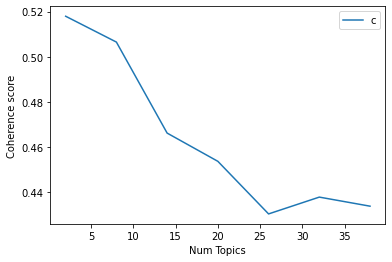

In [94]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [95]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5179
Num Topics = 8  has Coherence Value of 0.5065
Num Topics = 14  has Coherence Value of 0.4661
Num Topics = 20  has Coherence Value of 0.4536
Num Topics = 26  has Coherence Value of 0.4303
Num Topics = 32  has Coherence Value of 0.4377
Num Topics = 38  has Coherence Value of 0.4337


In [96]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.071*"elección" + 0.070*"decir" + 0.040*"hacer" + 0.033*"votar" + '
  '0.031*"trump" + 0.030*"noviembre" + 0.018*"electoral" + 0.017*"ahora" + '
  '0.017*"poder" + 0.016*"vez"'),
 (1,
  '0.029*"nuevo" + 0.018*"inmigrante" + 0.015*"ee_uu" + 0.014*"medir" + '
  '0.013*"acordar" + 0.012*"presentar" + 0.012*"anunciar" + 0.012*"querer" + '
  '0.011*"programar" + 0.011*"unir"'),
 (2,
  '0.207*"trump" + 0.131*"presidente" + 0.038*"dar" + 0.032*"coronavirus" + '
  '0.030*"hoy" + 0.029*"discursar" + 0.027*"detalle" + 0.022*"contar" + '
  '0.017*"positivo" + 0.015*"hablar"'),
 (3,
  '0.095*"presidente" + 0.075*"trump" + 0.036*"decir" + 0.016*"criticar" + '
  '0.015*"muerte" + 0.014*"juez" + 0.013*"ciudad" + 0.011*"familia" + '
  '0.010*"nominar" + 0.010*"padre"'),
 (4,
  '0.042*"coronavirus" + 0.033*"presidente" + 0.025*"casa_blanca" + '
  '0.025*"mandatario" + 0.024*"despues" + 0.022*"anunciar" + 0.020*"viernes" + '
  '0.016*"publicar" + 0.016*"pasar" + 0.016*"ser"'),
 (5,
  '0.070*"ca

##  Finding the dominant topic in each sentence

In [97]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2555,"nuevo, inmigrante, ee_uu, medir, acordar, pres...",La popular red social TikTok quedará eliminada...
1,1,0.0,0.1520,"elección, decir, hacer, votar, trump, noviembr...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
2,2,2.0,0.1581,"trump, presidente, dar, coronavirus, hoy, disc...","""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re..."
3,3,7.0,0.1500,"trump, ano, personar, millón, estadounidense, ...","""ESTA ES UNA MALDITA EMERGENCIA"". Gobernador d..."
4,4,4.0,0.1425,"coronavirus, presidente, casa_blanca, mandatar...",¡EN SU PROPIA CASA! A minutos de que BIDEN ac...
5,5,5.0,0.1682,"candidato, debatir, presidencial, democrata, c...",El astro boricua exhorta a votar por el candid...
6,6,7.0,0.1516,"trump, ano, personar, millón, estadounidense, ...","Simpatizantes de Trump asistieron al evento ""L..."
7,7,1.0,0.2077,"nuevo, inmigrante, ee_uu, medir, acordar, pres...",La decisión 2-1 pone en riesgo de deportación ...
8,8,0.0,0.1500,"elección, decir, hacer, votar, trump, noviembr...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
9,9,7.0,0.1838,"trump, ano, personar, millón, estadounidense, ...",¡REVELA SECRETO DE TRUMP! PATY NAVIDAD deja al...


## Find the most representative document for each topic

In [98]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
#pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4731,"elección, decir, hacer, votar, trump, noviembre, electoral, ahora, poder, vez","Trump sugirió que la gente en Carolina del Norte debería votar tanto por correo como de forma presencial. 😟 Pero, señor presidente, usted dijo miles de veces que los democratas se van a robar las elecciones cometiendo fraude electoral. ¿Ahora está instando a sus seguidores a hacer eso mismo? Trump sugirió que la gente en Carolina del Norte debería votar tanto por correo como de forma presencial. 😟 Pero, señor presidente, usted dijo miles de veces que los democratas se van a robar las elecciones cometiendo fraude electoral. ¿Ahora está instando a sus seguidores a hacer eso mismo?"
1,1.0,0.5372,"nuevo, inmigrante, ee_uu, medir, acordar, presentar, anunciar, querer, programar, unir","Benjamin Netanyahu: Estoy muy emocionado de haber hablado por teléfono con la delegación israelí en que estaba volando a Abu Dhabi en camino hacia la paz histórica. Después de tremendos esfuerzos que he liderado durante años, finalmente hemos traído ""paz por paz"". 🇮🇱🕊🇦🇪 Gracias presidente Trump. El vuelo ""LY971"" de la paz El histórico primer vuelo comercial entre Israel y Emiratos Árabes Unidos se llevo a cabo y el avión de El Al, la línea aérea de Israel aterrizó en Abu Dabi con funcionarios de Israel y de los Estados Unidos de América, luego de haber volado sobre el espacio aéreo saudí. Está delegación tendrá conversaciones con el gobierno de EAU para convenios de cooperación cívica y economía, tras el histórico acuerdo de paz entre Israel y Emiratos Árabes Unidos. El Primer Ministro de Israel, Benjamin Netanyahu - בנימין נתניהו habló telefónicamente con la delegación, desde su despacho, mientras el avión de El Al volaba a su histórico destino. Fotografias: Oficina de Prensa del Gobierno de Israel) Benjamin Netanyahu: Estoy muy emocionado de haber hablado por teléfono con la delegación israelí en que estaba volando a Abu Dhabi en camino hacia la paz histórica. Después de tremendos esfuerzos que he liderado durante años, finalmente hemos traído ""paz por paz"". 🇮🇱🕊🇦🇪 Gracias presidente Trump. El vuelo ""LY971"" de la paz El histórico primer vuelo comercial entre Israel y Emiratos Árabes Unidos se realizó el día de hoy y el avión de El Al, la línea aérea de Israel aterrizó en Abu Dabi con funcionarios de Israel y de los Estados Unidos de América, luego de haber volado sobre el espacio aéreo saudí. Está delegación tendrá conversaciones con el gobierno de EAU para convenios de cooperación cívica y economía, tras el histórico acuerdo de paz entre Israel y Emiratos Árabes Unidos. El Primer Ministro de Israel, Benjamin Netanyahu - בנימין נתניהו habló telefónicamente con la delegación, desde su despacho, mientras el avión de El Al volaba a su histórico destino. Fotografias: Oficina de Prensa del Gobierno de Israel)"
2,2.0,0.4242,"trump, presidente, dar, coronavirus, hoy, discursar, detalle, contar, positivo, hablar","Una corte le da luz verde a Trump para ponerle fin al TPS. Mientras tanto, el video de la emboscada contra la policía en Los Ángeles, aviva la controversia sobre las protestas, el racismo y la violencia en el país. Todo el análisis HOY en #PoliticaYa, con Tsi-tsi-ki Félix.http://notiya.info/z7ole63:=:http://lix.http://notiya.info/z7ole63 Una corte le da luz verde a Trump para ponerle fin al TPS. Mientras tanto, el video de la emboscada contra la policía en Los Ángeles, aviva la controversia sobre las protestas, el racismo y la violencia en el país. Todo el análisis, este domingo en #PoliticaYa, con Tsi-tsi-ki Félix. http://notiya.info/z7ole63:=:"
3,3.0,0.4341,"presidente, trump, decir, criticar, muerte, juez, ciudad, familia, nominar, padre","Queman vehículos y negocios por balazos policiales a Jacob Blake frente a sus hijos EFE Permanece gravemente hospitalizado, tras ser baleado siete veces frente a sus hijos en Wisconsin Queman vehículos y negocios por balazos policiales a Jacob Blake frente a sus hij

In [99]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"nuevo, inmigrante, ee_uu, medir, acordar, presentar, anunciar, querer, programar, unir",1450.0,0.1460
1.0,0.0,"elección, decir, hacer, votar, trump, noviembre, electoral, ahora, poder, vez",1221.0,0.1229
2.0,2.0,"trump, presidente, dar, coronavirus, hoy, discursar, detalle, contar, positivo, hablar",1390.0,0.1400
3.0,7.0,"trump, ano, personar, millón, estadounidense, llegar, politica, pagar, dolar, solo",1218.0,0.1226
4.0,4.0,"coronavirus, presidente, casa_blanca, mandatario, despues, anunciar, viernes, publicar, pasar, ser",1280.0,0.1289
5.0,5.0,"candidato, debatir, presidencial, democrata, campana, noticiar, ﻿1, destinar, noche, ultimar",1429.0,0.1439
6.0,7.0,"trump, ano, personar, millón, estadounidense, llegar, politica, pagar, dolar, solo",977.0,0.0984
7.0,1.0,"nuevo, inmigrante, ee_uu, medir, acordar, presentar, anunciar, querer, programar, unir",966.0,0.0973
